In [1]:
import numpy as np
import pandas as pd
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pickle
import cmath
import math
from scipy import io, stats
from scipy.stats import mannwhitneyu, normaltest, zscore, wilcoxon, ttest_rel
from statannotations.Annotator import Annotator
import matplotlib as mpl
import matplotlib.patheffects as path_effects

cwd = os.getcwd()
sys.path.append(cwd+"/../handy_functions")

from concat_pickles import get_outputs,get_outputs_wTraces,print_df
from metrics import get_R2

fig_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/figures/manuscript'

# Figure 1: How do the decoding models work?

16


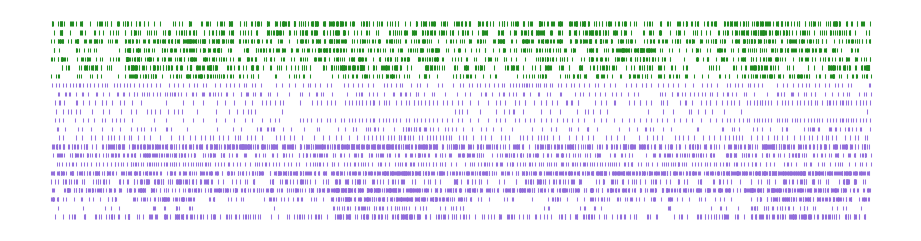

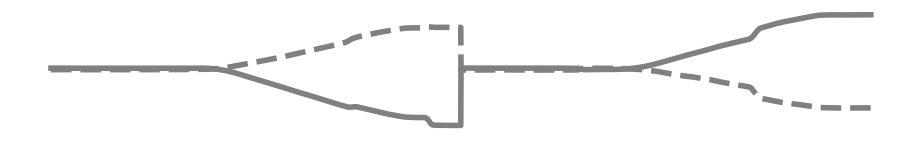

In [105]:
from preprocessing_funcs import bin_spikes
from preprocessing_funcs import bin_output

data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/datasets/'
dt = 50
data = io.loadmat(data_folder+'vars/vars-pa29dir4A-pre500-post300.mat')

spike_times  =  data['spike_times'] # spike times of all neurons
pos          =  data['pos'] # x and y eye positions
out_times    =  data['vels_times'] # times at which velocities were recorded
out_times    =  np.squeeze(out_times)

conditions = data['contConditions']

spike_times  =  np.squeeze(spike_times)
for i in range(spike_times.shape[0]):
    spike_times[i]  =  np.squeeze(spike_times[i])
    
unts = pd.read_csv(data_folder+'units/units-pa29dir4A-pre500-post300.csv')
fef = unts[(unts['signiffl'] == 1) & (unts['BrainArea'] == 'FEF') & (unts['DI'] > 0.15)].index
mt = unts[(unts['signiffl'] == 1) & (unts['BrainArea'] == 'MT') & (unts['DI'] > 0.15)].index
    
##############################################################################################
trial = [1858,1861] #1858. 1861. 1879. 1882. 1883.

spikes = []
for sublist in spike_times:
    s = sublist[np.logical_and(sublist>np.where(np.isin(conditions[:,0],trial))[0][0], sublist<np.where(np.isin(conditions[:,0],trial))[0][-1])]
    spikes.append(s)
    
fig, ax = plt.subplots(figsize=(10, 3))
fig.tight_layout()

test = [spikes[i] for i in fef]
print(len(test))

ax.eventplot([spikes[i] for i in fef], colors='mediumpurple', linelengths=0.5, linewidths=0.75, lineoffsets=np.arange(len([spikes[i] for i in fef])));
ax.eventplot([spikes[i] for i in mt], colors='forestgreen', linelengths=0.5, linewidths=0.75, lineoffsets=np.arange(len([spikes[i] for i in fef]),len([spikes[i] for i in fef])+len([spikes[i] for i in mt])));

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.savefig(fig_folder+'/examp_spikes.png', dpi=600, bbox_inches='tight')

##############################################################
fig2, ax = plt.subplots(figsize=(10, 2))
fig2.tight_layout()

poses = pos[np.isin(conditions[:,0],trial)]

ax.plot(-1*poses[:,0], label='HE', color='gray', linestyle='-', linewidth=4)
ax.plot(-1*poses[:,1], label='VE', color='gray', linestyle='--', linewidth=4)

#ax.set_xlim(400,900)

ax.axis('off')
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig2.savefig(fig_folder+'/examp_eyepos.png', dpi=600, bbox_inches='tight')

# Figure 2: How well do the decoding models perform?

In [65]:
data_folder = '/Users/kendranoneman/Projects/mayo/NeuralDecoding/runs'

pal = sns.color_palette("Reds",20)
pal = pal[8:]
custom_palette = sns.color_palette("Reds", n_colors=4)
mtfef_pal = ['forestgreen','mediumpurple']

column_names = ['sess','repeat','outer_fold','nMT','nFEF','model','R2','rho','R2_null','rho_null','time_elapsed']
df0,yTest_all0,yTestPred_all0,yTestN_all0,yTestNPred_all0 = get_outputs_wTraces(data_folder+'/Figure2',["-o0-","s29"],column_names)
df1,yTest_all1,yTestPred_all1,yTestN_all1,yTestNPred_all1 = get_outputs_wTraces(data_folder+'/Figure2',["-o1-","s29"],column_names)
df2,yTest_all2,yTestPred_all2,yTestN_all2,yTestNPred_all2 = get_outputs_wTraces(data_folder+'/Figure2',["-o2-","s29"],column_names)

df = pd.concat([df0,df1,df2],ignore_index=False)

df.head(11)

,sess,repeat,outer_fold,nMT,nFEF,model,time_elapsed,R2_x,R2_y,rho_x,rho_y,R2N_x,R2N_y,rhoN_x,rhoN_y,output
0,29,0,0,24,41,0,37.160122,0.633339,0.680768,0.797246,0.836006,-0.713105,-0.728356,-0.014400,-0.024110,position
1,29,0,1,24,41,0,35.522138,0.617187,0.685114,0.794708,0.829603,-0.732346,-0.677110,0.003316,-0.002979,position
2,29,0,2,24,41,0,35.496874,0.630212,0.669007,0.809284,0.827951,-0.656168,-0.718566,0.009550,0.014412,position
3,29,0,3,24,41,0,11.865045,0.636264,0.674148,0.803940,0.825867,-0.685862,-0.703134,0.003231,0.010029,position
4,29,0,4,24,41,0,16.237424,0.618645,0.677830,0.794446,0.831703,-0.650907,-0.640065,-0.000583,-0.010501,position
5,29,0,5,24,41,0,12.859240,0.601383,0.666728,0.802845,0.816628,-0.724489,-0.687129,0.010025,-0.014745,position
6,29,0,6,24,41,0,42.230611,0.642897,0.671609,0.816721,0.819524,-0.584197,-0.698992,0.028348,-0.008884,position
7,29,0,7,24,41,0,42.239831,0.637932,0.667992,0.805119,0.826533,-0.576325,-0.763128,0.012052,-0.014796,position
8,29,0,8,24,41,0,42.120314,0.591105,0.655180,0.810573,0.815908,-0.674655,-0.698122,0.006710,-0.002712,position
9,29,0,9,24,41,0,42.147781,0.638594,0.687125,0.804720,0.831144,-0.666414,-0.785317,-0.004980,0.015771,position


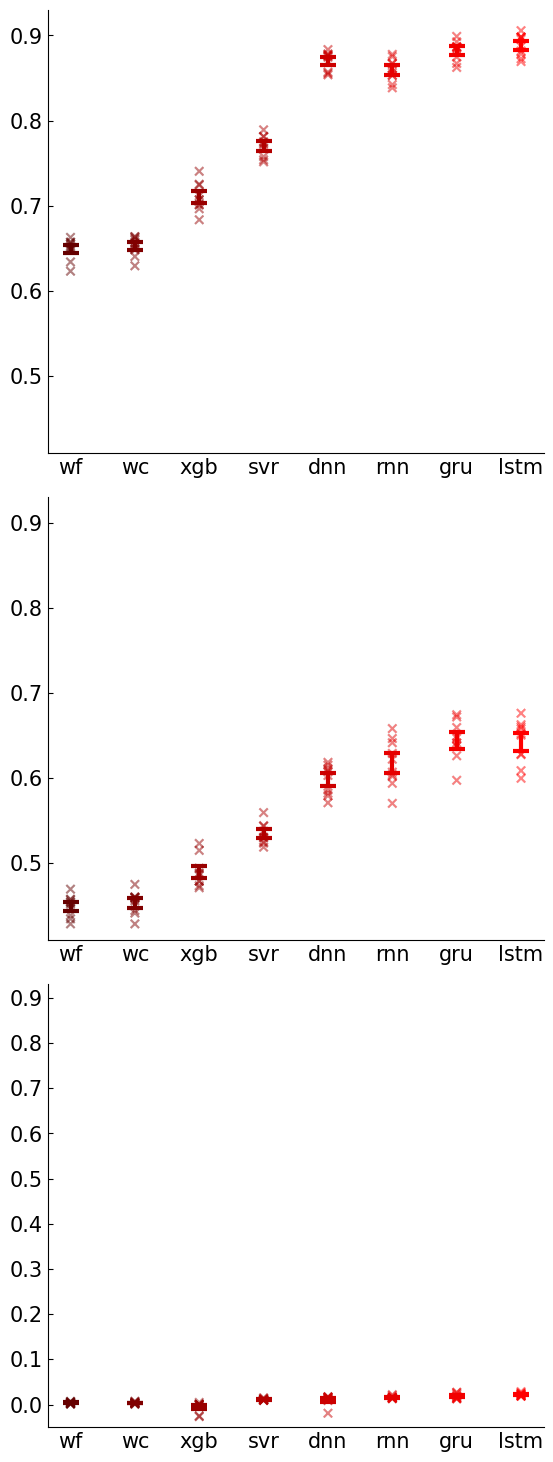

In [66]:
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(3,1,figsize=(6,15))
fig.tight_layout()
show_patrick = 0

#pal = sns.color_palette("Reds", n_colors=8, desat=1.0)
pal =[(1.0, 0.0, 0.0),   # Maroon
      (0.95, 0.0, 0.0),  # Lighter Red
      (0.9, 0.0, 0.0),   # Slightly Dark Red
      (0.8, 0.0, 0.0),   # Dark Red
      (0.7, 0.0, 0.0),   # Darker Red
      (0.6, 0.0, 0.0),   # Medium Red
      (0.5, 0.0, 0.0),   # Slightly Lighter Red
      (0.4, 0.0, 0.0)]
pal = pal[::-1]

sess = 29
values = ['R2_x','R2_y']
nulls = ['R2N_x','R2N_y']
outputs = ['position','velocity','acceleration']


for o in range(len(outputs)):
    wf   = (df.loc[(df['model']==0) & (df['sess']==sess) & (df['output']==outputs[o])][values]).mean(axis=1).values
    wc   = (df.loc[(df['model']==1) & (df['sess']==sess) & (df['output']==outputs[o])][values]).mean(axis=1).values
    xgb  = (df.loc[(df['model']==2) & (df['sess']==sess) & (df['output']==outputs[o])][values]).mean(axis=1).values
    svr  = (df.loc[(df['model']==3) & (df['sess']==sess) & (df['output']==outputs[o])][values]).mean(axis=1).values
    dnn  = (df.loc[(df['model']==4) & (df['sess']==sess) & (df['output']==outputs[o])][values]).mean(axis=1).values
    rnn  = (df.loc[(df['model']==5) & (df['sess']==sess) & (df['output']==outputs[o])][values]).mean(axis=1).values
    gru  = (df.loc[(df['model']==6) & (df['sess']==sess) & (df['output']==outputs[o])][values]).mean(axis=1).values
    lstm = (df.loc[(df['model']==7) & (df['sess']==sess) & (df['output']==outputs[o])][values]).mean(axis=1).values

    n=10
    means=([np.mean(wf),np.mean(wc),np.mean(xgb),np.mean(svr),np.mean(dnn),np.mean(rnn),np.mean(gru),np.mean(lstm)])
    err=([np.std(wf)*np.sqrt(1./n+1./(n-1)),np.std(wc)*np.sqrt(1./n+1./(n-1)),np.std(xgb)*np.sqrt(1./n+1./(n-1)),np.std(svr)*np.sqrt(1./n+1./(n-1)),np.std(dnn)*np.sqrt(1./n+1./(n-1)),np.std(rnn)*np.sqrt(1./n+1./(n-1)),np.std(gru)*np.sqrt(1./n+1./(n-1)),np.std(lstm)*np.sqrt(1./n+1./(n-1))])

    ind = np.arange(len(err)) #X values for plotting

    for pos, y, yerr, color in zip(ind, means, err, pal): #Loop through methods and plot error bars
        ax[o].errorbar(pos, y, yerr, lw=3, capsize=6, capthick=3, color=color, zorder=0)

        ax[o].set_xticks([0,1,2,3,4,5,6,7])
        ax[o].set_xticklabels(['wf','wc','xgb','svr','dnn','rnn','gru','lstm'], rotation=0)
        if o==2:
            
            ax[o].set_ylim([-0.05,0.93])
            ax[o].set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
            #ax[o].axhline(y=0, linestyle='--', color='black')
        else:
            #ax[o].set_xticklabels(['','','','','','','',''], rotation=0)
            ax[o].set_ylim([0.41,0.93])
            ax[o].set_yticks([0.5,0.6,0.7,0.8,0.9])
            

        #Remove right and top boundaries, and make ticks inward
        ax[o].tick_params(direction='in',bottom=0)
        ax[o].spines['right'].set_color('none')
        ax[o].spines['top'].set_color('none')
       # ax.set_yticks([0.6,0.7,0.8,0.9])
       # ax.set_ylim([0.55,0.9])

        #Plot individual R2 values for each fold as an 'x'
        scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(8)),(80,1)) #Get x values for plotting (first 10 will have an x value of 0, second 10 will have an x value of 1, etc)
        scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #Y values for plotting

        colors_list=[] #Create a list of the colors that should be used when plotting each 'x'
        for i in scatter_x.astype(int).reshape((1,-1))[0]:
            colors_list.append(pal[i])

        ax[o].scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=0.08,zorder=1)
        #if pos==0:
            #ax[o].scatter(scatter_x[4],scatter_y[4],facecolor='none',edgecolor='black',marker='o',s=90,zorder=2)
        #elif pos==7:
            #ax[o].scatter(scatter_x[74],scatter_y[74],facecolor='none',edgecolor='black',marker='o',s=90,zorder=2)


        # Perform Wilcoxon signed-rank test and add significance asterisks
        #R2_horz = R2_all[o][pos][:,0]
        #R2_vert = R2_all[o][pos][:,1]

#             R2_horz = (df.loc[(df['model']==0) & (df['sess']==29) & (df['output']=='position')]['R2_x']).values
#             R2_vert = (df.loc[(df['model']==0) & (df['sess']==29) & (df['output']=='position')]['R2_y']).values

#             p_value = wilcoxon(R2_horz,R2_vert)[1]

#             if p_value < 0.001:
#                 significance = '***'
#             elif p_value < 0.01:
#                 significance = '**'
#             elif p_value < 0.05:
#                 significance = '*'
#             else:
#                 significance = 'ns'

#             _, max_val = ax[o].get_ylim()
#             max_val_per_group = max(df[values[v]][(df['model'] == pos) & (df['sess']==sess) & (df['output']==outputs[o])].max(), df[nulls[v]][(df['model'] == pos) & (df['sess']==sess) & (df['output']==outputs[o])].max())
#             top_cap_y = max_val_per_group * 1.01

#             ax[o].text(pos, top_cap_y, significance, ha='center', va='bottom', fontsize=16)
            
plt.subplots_adjust(wspace=0.25, hspace=0.1)     
fig.savefig(fig_folder+'/R2_posVelAcc.png', dpi=600, bbox_inches='tight')

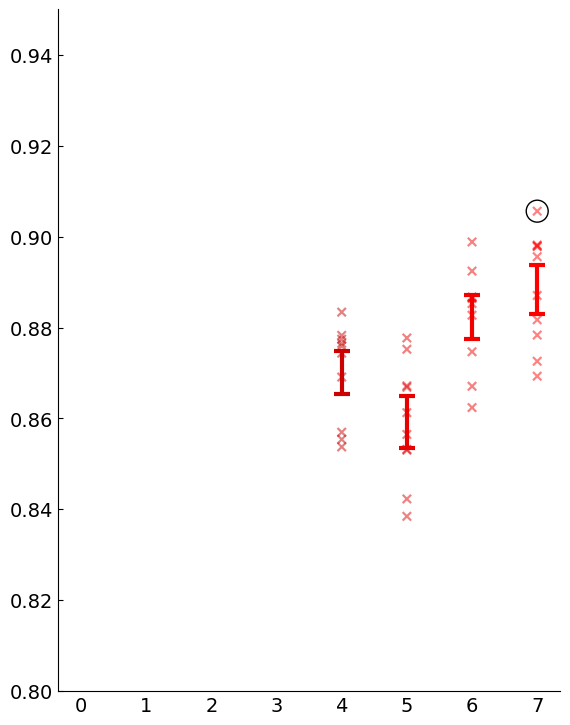

In [83]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1,figsize=(6,7.6),sharex=True)
fig.tight_layout()
show_patrick = 0

#pal = sns.color_palette("Reds", n_colors=8, desat=1.0)
pal =[(1.0, 0.0, 0.0),   # Maroon
      (0.95, 0.0, 0.0),  # Lighter Red
      (0.9, 0.0, 0.0),   # Slightly Dark Red
      (0.8, 0.0, 0.0),   # Dark Red
      (0.7, 0.0, 0.0),   # Darker Red
      (0.6, 0.0, 0.0),   # Medium Red
      (0.5, 0.0, 0.0),   # Slightly Lighter Red
      (0.4, 0.0, 0.0)]
pal = pal[::-1]

sess = 29
values = ['R2_x','R2_y']
nulls = ['R2N_x','R2N_y']
outputs = ['position','velocity','acceleration']

wf   = (df.loc[(df['model']==0) & (df['sess']==sess) & (df['output']==outputs[o])][values]).mean(axis=1).values
wc   = (df.loc[(df['model']==1) & (df['sess']==sess) & (df['output']==outputs[o])][values]).mean(axis=1).values
xgb  = (df.loc[(df['model']==2) & (df['sess']==sess) & (df['output']==outputs[o])][values]).mean(axis=1).values
svr  = (df.loc[(df['model']==3) & (df['sess']==sess) & (df['output']==outputs[o])][values]).mean(axis=1).values
dnn  = (df.loc[(df['model']==4) & (df['sess']==sess) & (df['output']==outputs[o])][values]).mean(axis=1).values
rnn  = (df.loc[(df['model']==5) & (df['sess']==sess) & (df['output']==outputs[o])][values]).mean(axis=1).values
gru  = (df.loc[(df['model']==6) & (df['sess']==sess) & (df['output']==outputs[o])][values]).mean(axis=1).values
lstm = (df.loc[(df['model']==7) & (df['sess']==sess) & (df['output']==outputs[o])][values]).mean(axis=1).values

n=10
means=([np.mean(wf),np.mean(wc),np.mean(xgb),np.mean(svr),np.mean(dnn),np.mean(rnn),np.mean(gru),np.mean(lstm)])
err=([np.std(wf)*np.sqrt(1./n+1./(n-1)),np.std(wc)*np.sqrt(1./n+1./(n-1)),np.std(xgb)*np.sqrt(1./n+1./(n-1)),np.std(svr)*np.sqrt(1./n+1./(n-1)),np.std(dnn)*np.sqrt(1./n+1./(n-1)),np.std(rnn)*np.sqrt(1./n+1./(n-1)),np.std(gru)*np.sqrt(1./n+1./(n-1)),np.std(lstm)*np.sqrt(1./n+1./(n-1))])

ind = np.arange(len(err)) #X values for plotting

o = 0

for pos, y, yerr, color in zip(ind, means, err, pal): #Loop through methods and plot error bars
    ax.errorbar(pos, y, yerr, lw=3, capsize=6, capthick=3, color=color, zorder=0)
    ax.set_ylim([0.8,0.95])

    #Remove right and top boundaries, and make ticks inward
    ax.tick_params(direction='in',bottom=0)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
   # ax.set_yticks([0.6,0.7,0.8,0.9])
   # ax.set_ylim([0.55,0.9])

    #Plot individual R2 values for each fold as an 'x'
    scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(8)),(80,1)) #Get x values for plotting (first 10 will have an x value of 0, second 10 will have an x value of 1, etc)
    scatter_y=np.concatenate((wf,wc,xgb,svr,dnn,rnn,gru,lstm),axis=0) #Y values for plotting

    colors_list=[] #Create a list of the colors that should be used when plotting each 'x'
    for i in scatter_x.astype(int).reshape((1,-1))[0]:
        colors_list.append(pal[i])

    ax.scatter(scatter_x,scatter_y,c=colors_list,marker='x',alpha=0.08,zorder=1)
    if pos==7:
        ax.scatter(scatter_x[74],scatter_y[74],facecolor='none',edgecolor='black',marker='o',s=250,zorder=2)
            
plt.subplots_adjust(wspace=0.25, hspace=0.1)     
fig.savefig(fig_folder+'/R2_posVelAcc_zoom.png', dpi=600, bbox_inches='tight')

[1858. 1861. 1879. 1882. 1883.]


NameError: name 'blah' is not defined

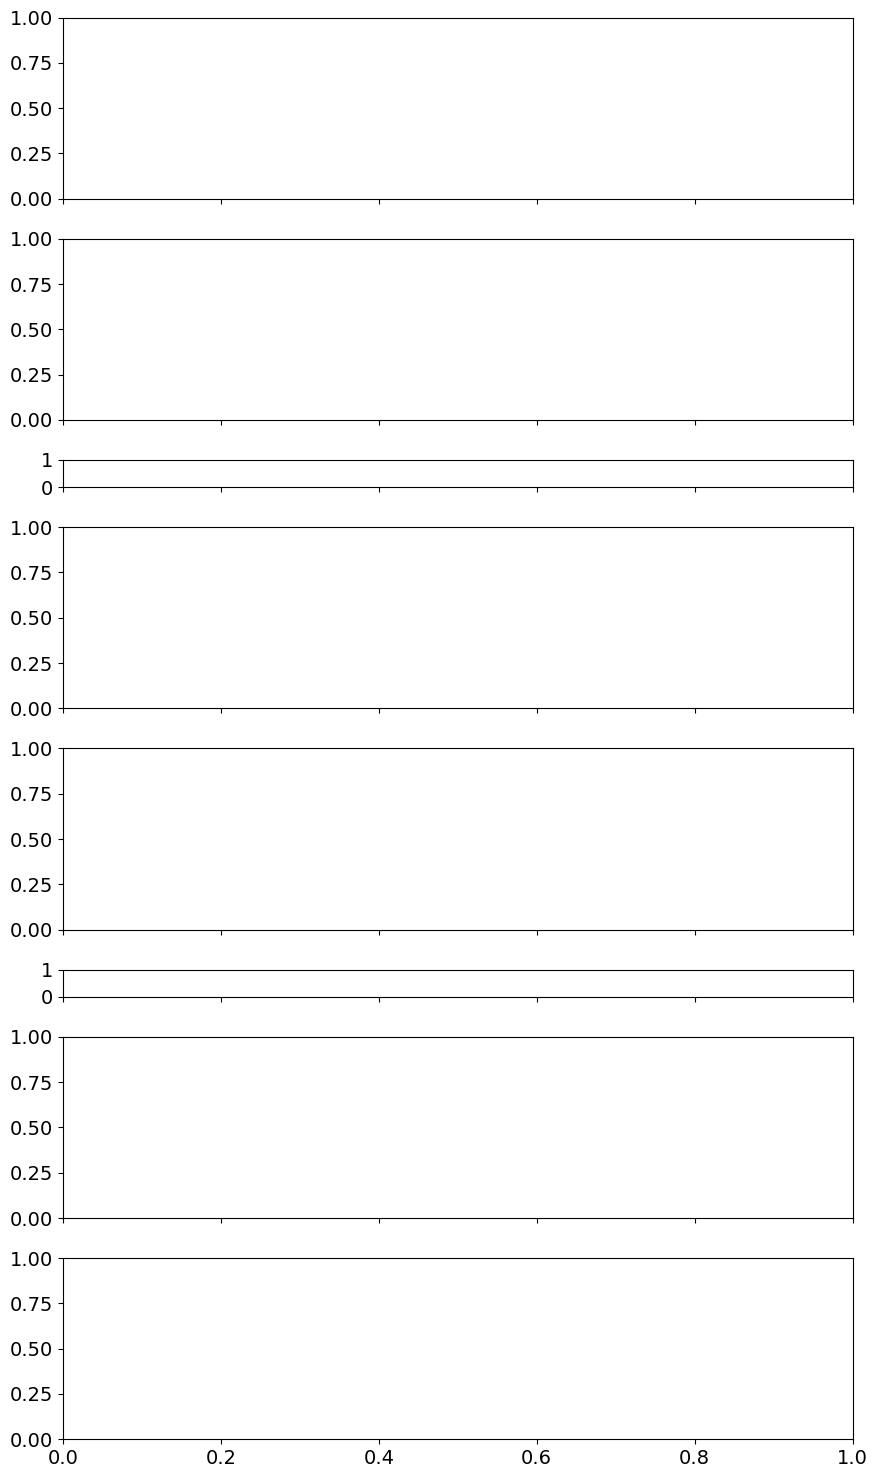

In [67]:
 plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(8,1,figsize=(9,15),sharex=True,gridspec_kw={'height_ratios': [2,2,0.3,2,2,0.3,2,2]})
fig.tight_layout()

y_test = yTest_all0
y_test_predicted = yTestPred_all0
DF = df0

mean_values = DF[['R2_x','R2_y']].mean(axis=1)
mi = mean_values.idxmax()

mdls = np.arange(mi-70,mi+1,10)
jmdls = range(len(mdls))

#mdls = [4,74]
#jmdls = [0,7]
lstyles = ['dotted','dotted','dotted','dotted','dotted','dashed','dashed','dashed']
if len(jmdls) < 3:
    lw = 1.5
else:
    lw = 1

with open(data_folder+'/Figure2/s29-t0-d050-m{:02d}-o0-nm24-nf41-bn1-fo10-fi01/fold{:02d}.pickle'.format(DF.loc[mi]['model'],DF.loc[mi]['outer_fold']), 'rb') as f:
    _,conds,_,_,_,_ = pickle.load(f)

trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

plot_trls = np.array([3,6,24,27,28])
print(trl_nums[plot_trls])

print(blah)
start_end = np.where(np.isin(conds[:, 0],trl_nums[plot_trls]))[0]
x = np.arange(0, start_end.shape[0]*50, 50) / 1000

axes[0].plot(x,y_test[mi][start_end,0], color=(0.3,0.3,0.3), alpha=0.5, linewidth=2.5, label='true (horizontal)',zorder=0)
for i,j in zip(mdls,jmdls):
    axes[0].plot(x,y_test_predicted[i][start_end,0], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted (horizontal)',zorder=j+1)
    axes[0].plot(x,y_test_predicted[i][start_end,0], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted2 (horizontal)',zorder=j+1)


axes[0].set_xlim(x[0],x[-1]-0.95)
axes[0].set_ylim(-13,14.5)
axes[0].set_yticks([-10,0,10])
axes[0].spines['right'].set_color('none')
axes[0].spines['top'].set_color('none')
axes[0].tick_params(axis='x', which='both', bottom=False, top=False)
axes[0].spines['bottom'].set_visible(False)


axes[1].plot(x,y_test[mi][start_end,1], color=(0.3,0.3,0.3), alpha=0.5, linewidth=2.5, label='true (vertical)',zorder=0)
for i,j in zip(mdls,jmdls):
    axes[1].plot(x,y_test_predicted[i][start_end,1], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted (horizontal)',zorder=j+1)
    axes[1].plot(x,y_test_predicted[i][start_end,1], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted2 (horizontal)',zorder=j+1)

    X_true = y_test[i][start_end,0]
    Y_true = y_test[i][start_end,1]

    X_pred = y_test_predicted[i][start_end,0]
    Y_pred = y_test_predicted[i][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))

    axes[1].text(6.5, 23-(j*2.4), r"$R^2 = $" + f"{R2.mean():.2f}", verticalalignment='center', color=pal[j], fontsize=10)
    #axes[1].text(6.3, -9-(j*0.4), r"$R^2 = $" + f"{R2[1]:.2f}", verticalalignment='center', color=pal[j], fontsize=10)
    
    #axes[0].text(7.1, (-10)-(j*1.0), r"$R^2 = $" + f"{R2.mean():.2f}", verticalalignment='center', color=pal[j], fontsize=10)
    
axes[1].set_ylim(-15.5,12.5)
axes[1].set_yticks([-10,0,10])
axes[1].spines['right'].set_color('none')
axes[1].spines['top'].set_color('none')

for o in range(2):
    if o==0:
        y_test = yTest_all1
        y_test_predicted = yTestPred_all1
        DF = df1
        oo = [3,4]
    else:
        y_test = yTest_all2
        y_test_predicted = yTestPred_all2
        DF = df2
        oo = [6,7]
        
    axes[oo[0]].plot(x,y_test[mi][start_end,0], color=(0.3,0.3,0.3), alpha=0.5, linewidth=2.5, label='true (horizontal)', zorder=0)
    for i,j in zip(mdls,jmdls):
        axes[oo[0]].plot(x,y_test_predicted[i][start_end,0], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted (horizontal)',zorder=j+1)
        axes[oo[0]].plot(x,y_test_predicted[i][start_end,0], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted2 (horizontal)',zorder=j+1)

    axes[oo[0]].set_xlim(x[0],x[-1]-0.95)
    axes[oo[0]].spines['right'].set_color('none')
    axes[oo[0]].spines['top'].set_color('none')
    axes[oo[0]].tick_params(axis='x', which='both', bottom=False, top=False)
    axes[oo[0]].spines['bottom'].set_visible(False)

    axes[oo[1]].plot(x,y_test[mi][start_end,1], color=(0.3,0.3,0.3), alpha=0.5, linewidth=2.5, label='true (vertical)', zorder=0)
    for i,j in zip(mdls,jmdls):
        axes[oo[1]].plot(x,y_test_predicted[i][start_end,1], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted (horizontal)',zorder=j+1)
        axes[oo[1]].plot(x,y_test_predicted[i][start_end,1], color=pal[j], linewidth=lw, linestyle=lstyles[j], label='predicted2 (horizontal)',zorder=j+1)

        X_true = y_test[i][start_end,0]
        Y_true = y_test[i][start_end,1]

        X_pred = y_test_predicted[i][start_end,0]
        Y_pred = y_test_predicted[i][start_end,1]

        R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))

        if o==0:
            axes[oo[1]].text(6.5, 58-(j*6), r"$R^2 = $" + f"{R2.mean():.2f}", verticalalignment='center', color=pal[j], fontsize=10)
            #axes[oo[1]].text(6.3, -24-(j*1), r"$R^2 = $" + f"{R2[1]:.2f}", verticalalignment='center', color=pal[j], fontsize=10)
        else:
            axes[oo[1]].text(6.5, 257-(j*23), r"$R^2 = $" + f"{R2.mean():.2f}", verticalalignment='center', color=pal[j], fontsize=10)
            #axes[oo[1]].text(6.3, -145-(j*6.5), r"$R^2 = $" + f"{R2[1]:.2f}", verticalalignment='center', color=pal[j], fontsize=10)
        
    axes[oo[1]].set_xlim(x[0],x[-1]-0.95)
    axes[oo[1]].spines['right'].set_color('none')
    axes[oo[1]].spines['top'].set_color('none')
    
    if o==0:
        axes[oo[0]].set_yticks([-25,0,25])
        axes[oo[1]].set_yticks([-25,0,25])
        axes[oo[0]].set_ylim(-40,40)
        axes[oo[1]].set_ylim(-40,30)
    else:
        axes[oo[0]].set_yticks([-100,0,100])
        axes[oo[1]].set_yticks([-100,0,100])
        axes[oo[0]].set_ylim(-150,150)
        axes[oo[1]].set_ylim(-150,150)
    
axes[2].axis('off')
axes[5].axis('off')
        
plt.subplots_adjust(wspace=0.25, hspace=0.1)
fig.savefig(fig_folder+'/predicted_PosVelAcc.png', dpi=600, bbox_inches='tight') 

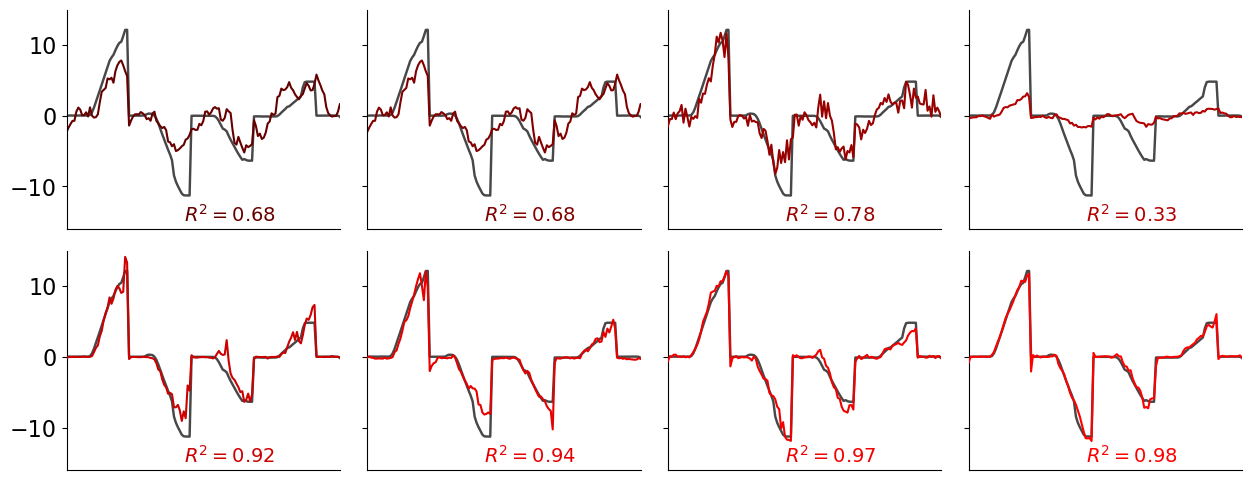

In [204]:
 plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(2,4,figsize=(13,5.5),sharex=True,sharey=True)
fig.tight_layout()

y_test = yTest_all0
y_test_predicted = yTestPred_all0
DF = df0

mean_values = DF[['R2_x','R2_y']].mean(axis=1)
mi = mean_values.idxmax()

mdls = np.arange(mi-70,mi+1,10)
jmdls = range(len(mdls))

with open(data_folder+'/Figure2/s29-t0-d050-m{:02d}-o0-nm24-nf41-bn1-fo10-fi01/fold{:02d}.pickle'.format(DF.loc[mi]['model'],DF.loc[mi]['outer_fold']), 'rb') as f:
    _,conds,_,_,_,_ = pickle.load(f)

trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

plot_trls = np.array([3,6,24,27,28])
start_end = np.where(np.isin(conds[:, 0],trl_nums[plot_trls]))[0]
x = np.arange(0, start_end.shape[0]*50, 50) / 1000

for ind, (ax,i,j) in enumerate(zip(axes.flatten(),mdls,jmdls)):
    ax.plot(x,y_test[i][start_end,0], color=(0.1,0.1,0.1), alpha=0.8, linewidth=1.75, label='true (horizontal)',zorder=0)
    #ax.plot(x,y_test[i][start_end,1], color=(0.1,0.1,0.1), alpha=0.8, linewidth=2, linestyle='dotted', label='true (horizontal)',zorder=0)

    ax.plot(x,y_test_predicted[i][start_end,0], color=pal[j], linewidth=1.5, label='predicted (horizontal)',zorder=j+1)
    #ax.plot(x,y_test_predicted[i][start_end,1], color=pal[j], linewidth=1.75, linestyle='dotted', label='predicted2 (horizontal)',zorder=j+1)

    X_true = y_test[i][start_end,0]
    Y_true = y_test[i][start_end,1]

    X_pred = y_test_predicted[i][start_end,0]
    Y_pred = y_test_predicted[i][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))

    ax.text(3, -14, r"$R^2 = $" + f"{R2[0]:.2f}", verticalalignment='center', color=pal[j], fontsize=14)
    
    
    ax.set_xlim(x[0],x[-1]-0.95)
    ax.set_ylim(-16,15)
    ax.set_yticks([-10,0,10])
    ax.set_xticks([])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.savefig(fig_folder+'/predicted_Pos.png', dpi=600, bbox_inches='tight')


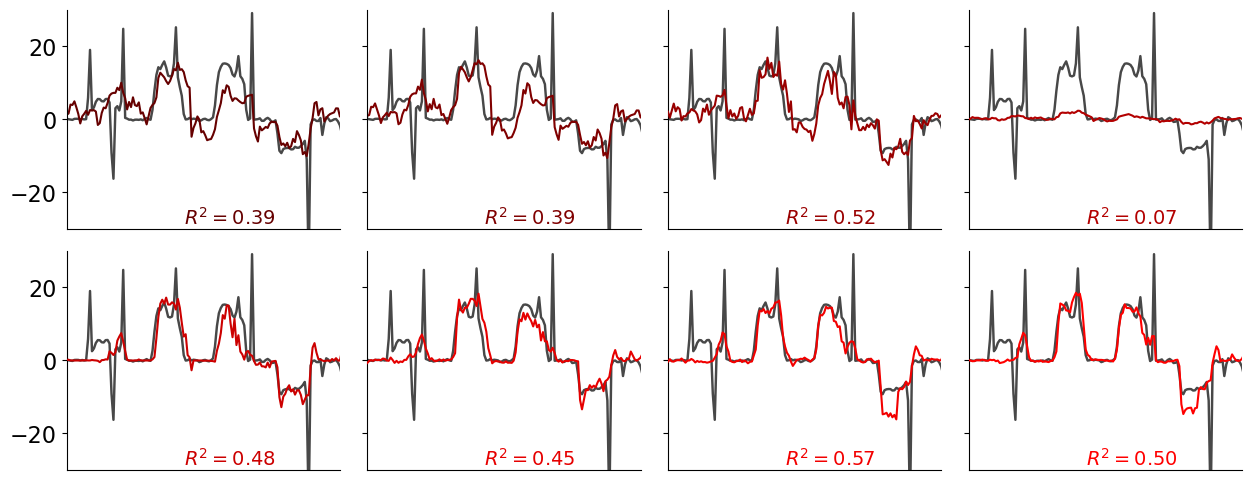

In [205]:
 plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(2,4,figsize=(13,5.5),sharex=True,sharey=True)
fig.tight_layout()

y_test = yTest_all1
y_test_predicted = yTestPred_all1
DF = df1

mean_values = DF[['R2_x','R2_y']].mean(axis=1)
mi = mean_values.idxmax()

mdls = np.arange(mi-70,mi+1,10)
jmdls = range(len(mdls))

with open(data_folder+'/Figure2/s29-t0-d050-m{:02d}-o0-nm24-nf41-bn1-fo10-fi01/fold{:02d}.pickle'.format(DF.loc[mi]['model'],DF.loc[mi]['outer_fold']), 'rb') as f:
    _,conds,_,_,_,_ = pickle.load(f)

trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

plot_trls = np.array([3,6,24,27,28])
start_end = np.where(np.isin(conds[:, 0],trl_nums[plot_trls]))[0]
x = np.arange(0, start_end.shape[0]*50, 50) / 1000

for ind, (ax,i,j) in enumerate(zip(axes.flatten(),mdls,jmdls)):
    ax.plot(x,y_test[i][start_end,0], color=(0.1,0.1,0.1), alpha=0.8, linewidth=1.75, label='true (horizontal)',zorder=0)
    #ax.plot(x,y_test[i][start_end,1], color=(0.1,0.1,0.1), alpha=0.8, linewidth=2, linestyle='dotted', label='true (horizontal)',zorder=0)

    ax.plot(x,y_test_predicted[i][start_end,0], color=pal[j], linewidth=1.5, label='predicted (horizontal)',zorder=j+1)
    #ax.plot(x,y_test_predicted[i][start_end,1], color=pal[j], linewidth=1.75, linestyle='dotted', label='predicted2 (horizontal)',zorder=j+1)

    X_true = y_test[i][start_end,0]
    Y_true = y_test[i][start_end,1]

    X_pred = y_test_predicted[i][start_end,0]
    Y_pred = y_test_predicted[i][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))

    ax.text(3, -27, r"$R^2 = $" + f"{R2[0]:.2f}", verticalalignment='center', color=pal[j], fontsize=14)
    
    
    ax.set_xlim(x[0],x[-1]-0.95)
    ax.set_xticks([])
    ax.set_ylim(-30,30)
    #ax.set_yticks([-20,0,20])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.savefig(fig_folder+'/predicted_Vel.png', dpi=600, bbox_inches='tight')

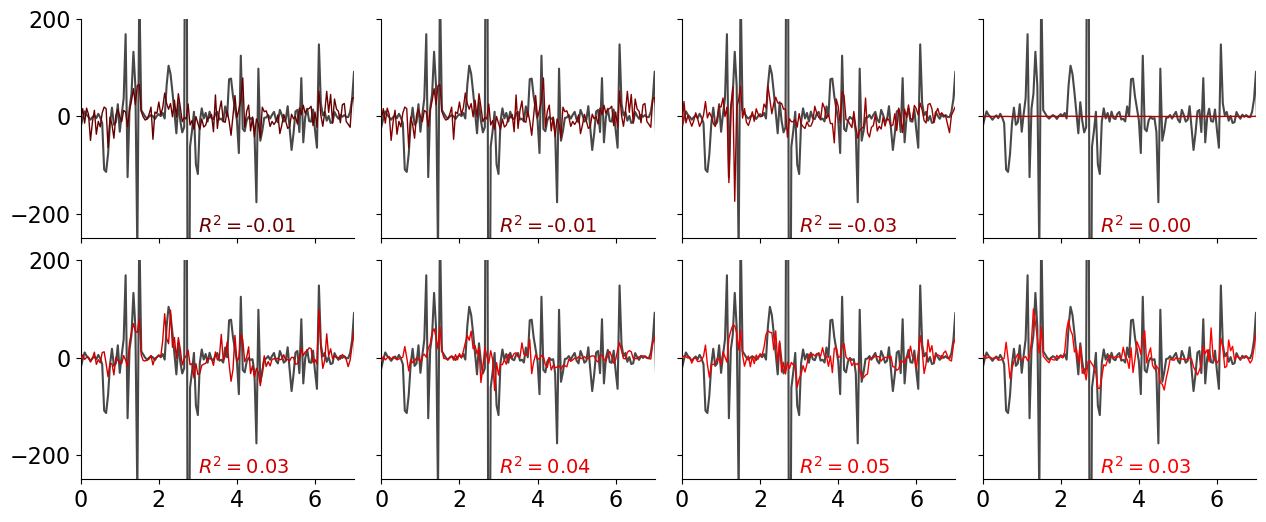

In [207]:
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(2,4,figsize=(13,5.5),sharex=True,sharey=True)
fig.tight_layout()

y_test = yTest_all2
y_test_predicted = yTestPred_all2
DF = df2

mean_values = DF[['R2_x','R2_y']].mean(axis=1)
mi = mean_values.idxmax()

mdls = np.arange(mi-70,mi+1,10)
jmdls = range(len(mdls))

with open(data_folder+'/Figure2/s29-t0-d050-m{:02d}-o0-nm24-nf41-bn1-fo10-fi01/fold{:02d}.pickle'.format(DF.loc[mi]['model'],DF.loc[mi]['outer_fold']), 'rb') as f:
    _,conds,_,_,_,_ = pickle.load(f)

trl_nums = np.unique(conds[:,0])
trl_nums, indices = np.unique(conds[:,0], return_index=True)
trl_dirs = conds[indices,3]

plot_trls = np.array([3,6,24,27,28])
start_end = np.where(np.isin(conds[:, 0],trl_nums[plot_trls]))[0]
x = np.arange(0, start_end.shape[0]*50, 50) / 1000

for ind, (ax,i,j) in enumerate(zip(axes.flatten(),mdls,jmdls)):
    ax.plot(x,y_test[i][start_end,0], color=(0.1,0.1,0.1), alpha=0.8, linewidth=1.5, label='true (horizontal)',zorder=0)
    #ax.plot(x,y_test[i][start_end,1], color=(0.1,0.1,0.1), alpha=0.8, linewidth=1.5, linestyle='dotted', label='true (horizontal)',zorder=0)

    ax.plot(x,y_test_predicted[i][start_end,0], color=pal[j], linewidth=1, label='predicted (horizontal)',zorder=j+1)
    #ax.plot(x,y_test_predicted[i][start_end,1], color=pal[j], linewidth=1, linestyle='dotted', label='predicted2 (horizontal)',zorder=j+1)

    X_true = y_test[i][start_end,0]
    Y_true = y_test[i][start_end,1]

    X_pred = y_test_predicted[i][start_end,0]
    Y_pred = y_test_predicted[i][start_end,1]

    R2 = get_R2(np.concatenate((X_true.reshape(-1,1),Y_true.reshape(-1,1)),axis=1),np.concatenate((X_pred.reshape(-1,1),Y_pred.reshape(-1,1)),axis=1))

    ax.text(3, -225, r"$R^2 = $" + f"{R2[0]:.2f}", verticalalignment='center', color=pal[j], fontsize=14)
    
    
    ax.set_xlim(x[0],x[-1]-0.95)
    #ax.set_xticks([])
    ax.set_ylim(-250,200)
    #ax.set_yticks([-20,0,20])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.savefig(fig_folder+'/predicted_Acc.png', dpi=600, bbox_inches='tight')

# Figure 3: ...